### Instructions

This notebook was written to estimate the 'coupling' effect in continuous biological signals such as EEG, EMG, etc. between 2 subjects.

The setup required to use this notebook is a simple organization of a folder in your google drive and the definition of a few constants below.

The notebook automatically connects to the google drive of the user.




#### The Format of the Data



This notebook supports analysis of data from two subjects.

The numpy arrays in the npz should be in shape - (number_of_channels, channel_length).

For example, if we have 2 signals per subject and a a length of 10000 samples for the experiment

We would have 2 np arrays of shape (2,10000).

#### Organization of the Data



All of the data for the experiment should be organized in a main folder.

The data for each session of the experiment should be contained in sub folders within the main folder.

In each sub folder, the 2 .npz files of the 2 subject should reside.

##### Within Google Drive

Please create a folder in your google drive, called 'Shortcuts to Data'.

Within this folder place a shortcut to the 'main folder' described above.

#### Defining the Constants


    RUNNING_FROM_COLAB

Should be 'True' if you are running the notebook in google colab (in your browser).

When running locally please set to 'False'.

    FOLDER_PATH

This constant should hold the name of the 'main folder' of the experiment.

    SESSION_FOLDER
    
This constant should hold the name of the 'sub folder' of the sessions.

    PARTICIPANT_A_FILE & PARTICIPANT_B_FILE

These 2 constants should hold the file names of the two .npz files of the 2 subjects.

Thus the path to one participant file within your drive should look like:

'Shortcuts To Data/[EXPERIMENT_FOLDER]/[SESSION_FOLDER]/[PARTICIPANT_A_FILE]'.

    ORIG_SAMPLE_RATE

The original sample rate of the data. (in Hz)

    SAMPLE_RATE

The sample rate to work with for the analysis. The data will be downsampled from ORIG_SAMPLE_RATE to SAMPLE_RATE. (in Hz)

    EXTRACT_FREQUENCIES

Should be 'True' if you want to extract the different EEG frequency bands for the analysis.

    FIND_BEST_LAG & MAXIMUM_LAG_FOR_SEARCH

The first should be set true if you want the algorithm to search for the best lag order. (not recommended - cpu intensive).

The second will be max number of seconds to search.

    LAG_ORDER

This constant holds the lag order of the VAR model which determines 'how far back' in seconds to look at the other signal for coupling.

    TRIM_5

If this is set 'True' the data will be trimmed to only anlyze the first 5 minutes of the session.

    COUPLING_TYPE

1 vs 1 will search for coupling between signals of the same type between the subjects.
1 vs all will search for coupling between each signal and all of the signals from the other subject.
all vs all will search for coupling between all of the signals of the 2 subjects.

    COUPLING_TESTS

If set to 'True', will showcase demonstrations of the coupling algoeithm on a short sample of the signal.

This should be set 'False' when running the algorithm for results on a real experiment as it is cpu intensive.

#### Running the Algorithm

After the setup and definition of the constants, please click on the 'runtime' button and then on 'run all'.

During the operation of the notebook, a request to approve access to google drive will pop up - click accept.

The results will be shown in the bottom of the notebook in the form of FPE or 'final prediction error' of the model.

### ===================================================================================

### Constants




In [111]:
RUNNING_FROM_COLAB = True

FOLDER_PATH = "Shortcuts to Data/Try" # The folder of the data.
SESSION_FOLDER = "04122022_1545" # The folder containing the session's data.
PARTICIPANT_A_FILE = "EEG_channels_A.npz" # npz file
PARTICIPANT_B_FILE = "EEG_channels_B.npz" # npz file

ORIG_SAMPLE_RATE = 4000 # hz
SAMPLE_RATE = 100 # hz

EXTRACT_FREQUENCIES = True # Extract the different frequency power levels for the coupling algorithm (relevant for EEG).

FIND_BEST_LAG = False # Search for the best lag.
MAXIMUM_LAG_FOR_SEARCH = 3 # The maximum lag for the algorithm to choose.

LAG_ORDER = 2 # The lag which the algorithm will use to search for coupling.

TRIM_5 = True # Test only on the first 5 minutes of each signal.

COUPLING_TYPE = 1
# 1: 1 vs 1
# 2: 1 vs all
# 3: all vs all

COUPLING_TESTS = False # Showcase coupling algorithm tests.

### Dependancies

In [112]:
# !pip install mne

In [113]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pywt
import scipy.io as spio
from scipy.stats import entropy
from collections import Counter

from sklearn import svm
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report

import timeit
from tqdm import tqdm

from pywt import wavedec
import pywt

import statsmodels.api as sm
from numpy.linalg import LinAlgError
import statsmodels.api as sm

### Mount to Drive

In [114]:
# This mounts Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# The foldername in the Drive where the images are saved.
# This folder needs to be directly under the My Drive folder.
FOLDERNAME = 'TomerGuyOmri-Seminar'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# This ensures that the Python interpreter of the Colab VM
# can load python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Receive Data

In [115]:
if RUNNING_FROM_COLAB:
  FOLDER_PATH = "/content/drive/MyDrive/" + FOLDER_PATH

In [116]:
path_A = os.path.join(FOLDER_PATH, SESSION_FOLDER, PARTICIPANT_A_FILE)
npz_A = np.load(path_A)
print(f'npz A content: {npz_A.files}')
shape = npz_A['arr_0'].shape
print(f'arr_0 shape: {shape}')
np_A = npz_A['arr_0']
print('==================')

path_B = os.path.join(FOLDER_PATH, SESSION_FOLDER, PARTICIPANT_B_FILE)
npz_B = np.load(path_B)
print(f'npz B content: {npz_B.files}')
shape = npz_B['arr_0'].shape
print(f'arr_0 shape: {shape}')
np_B = npz_B['arr_0']
print('==================')

npz A content: ['arr_0']
arr_0 shape: (2, 6811172)
npz B content: ['arr_0']
arr_0 shape: (2, 6802496)


### Preprocessing

In [117]:
def reset_dimensions(arr):
  if len(arr.shape) == 1:
    arr = arr.reshape((1,arr.shape[0]))
  return arr

In [118]:
np_A = reset_dimensions(np_A)
np_B = reset_dimensions(np_B)

In [119]:
NUMBER_OF_CHANNELS = np_A.shape[0]
print(f'Number of channels: {NUMBER_OF_CHANNELS}')

Number of channels: 2


In [120]:
def trim_matrices_to_min_length(np_A, np_B):
    # Find the minimum row length from both matrices
    min_row_length = min(np_A.shape[1], np_B.shape[1])

    if TRIM_5:
      min_row_length = min(min_row_length, ORIG_SAMPLE_RATE*60*5)

    # Trim the rows of np_A and np_B to the minimum row length
    np_A_trimmed = np_A[:, :min_row_length]
    np_B_trimmed = np_B[:, :min_row_length]

    return (np_A_trimmed, np_B_trimmed)

In [121]:
print(np_A.shape)
print(np_B.shape)

np_A, np_B = trim_matrices_to_min_length(np_A, np_B)

print(np_A.shape)
print(np_B.shape)

(2, 6811172)
(2, 6802496)
(2, 1200000)
(2, 1200000)


In [122]:
import numpy as np
from scipy import signal

def downsample_eeg(eeg_data, method='decimate'):
    original_sample_rate = ORIG_SAMPLE_RATE
    sample_rate = SAMPLE_RATE

    # Calculate the downsampling factor
    downsampling_factor = original_sample_rate // sample_rate

    # Check if downsampling is required
    if downsampling_factor == 1:
        return eeg_data

    # Apply downsampling method
    if method == 'decimate':
        # Decimate using scipy's decimate function
        downsampled_data = signal.decimate(eeg_data, downsampling_factor, zero_phase=True)
    elif method == 'average':
        # Reshape the data into non-overlapping windows
        num_samples = len(eeg_data)
        num_windows = num_samples // downsampling_factor
        windowed_data = eeg_data[:num_windows * downsampling_factor].reshape(num_windows, downsampling_factor)

        # Take the average of each window
        downsampled_data = np.mean(windowed_data, axis=1)
    else:
        raise ValueError("Invalid downsampling method. Supported methods: 'decimate', 'average'")

    return downsampled_data

In [123]:
def sample_len_to_min(eeg_data):
  return eeg_data.shape[0] / SAMPLE_RATE / 60

In [124]:
def stack_channels(arr):
  channel_list = []
  for channel in range(NUMBER_OF_CHANNELS):
    channel_list.append(downsample_eeg(arr[channel]))
  return channel_list

In [125]:
np_A_ready = np.vstack(stack_channels(np_A))
print(f'np_A_ready shape: {np_A_ready.shape}')

np_B_ready = np.vstack(stack_channels(np_B))
print(f'np_B_ready shape: {np_B_ready.shape}')

np_A_ready shape: (2, 30000)
np_B_ready shape: (2, 30000)


### Feature Extraction

#### Extract Frequency Powers

In [126]:
import numpy as np
from scipy.signal import cwt, morlet

def extract_frequency_powers(np_array):
    # Define the desired frequency bands along with their corresponding scales
    frequency_bands = {
        'delta': np.arange(1, 4),
        'theta': np.arange(4, 8),
        'alpha': np.arange(8, 12),
        'beta':  np.arange(12, 30),
        'gamma': np.arange(30, 100)
    }

    num_samples = len(np_array)
    power_values = {band: np.zeros(num_samples) for band in frequency_bands}

    for band, frequencies in frequency_bands.items():
        scales = 5*SAMPLE_RATE / (2*frequencies*np.pi)
        scales = (np.rint(scales)).astype(int)

        # Apply the Continuous Wavelet Transform (CWT) using Morlet wavelet and the given scales
        wavelet_transform = cwt(np_array, morlet, scales)

        # Calculate the power as the squared magnitude of the wavelet coefficients
        power = np.square(np.abs(wavelet_transform))

        # Sum the power values within the frequency band
        band_power = np.sum(power, axis=0)

        # Store the band power values in the dictionary
        power_values[band] = band_power

    return power_values

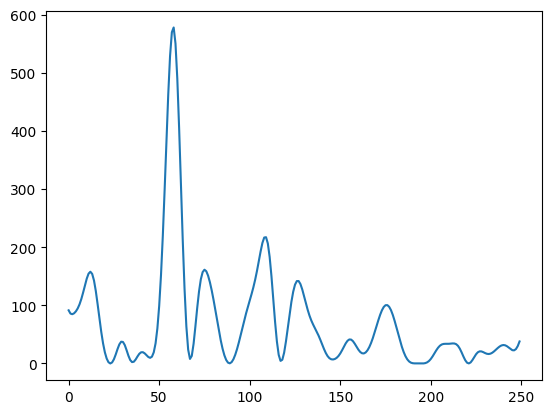

In [127]:
frequencies = np.arange(12,13) # extract 12 hz
scales = 5*SAMPLE_RATE / (2*frequencies*np.pi)
scales = x = (np.rint(scales)).astype(int)

# Apply the Continuous Wavelet Transform (CWT) using Morlet wavelet and the given scales
wavelet_transform = cwt(np_A_ready[0], morlet, scales)

# Calculate the power as the squared magnitude of the wavelet coefficients
power = np.square(np.abs(wavelet_transform))

# Sum the power values within the frequency band
band_power = np.sum(power, axis=0)

# Store the band power values in the dictionary
plt.plot(band_power[100:350])

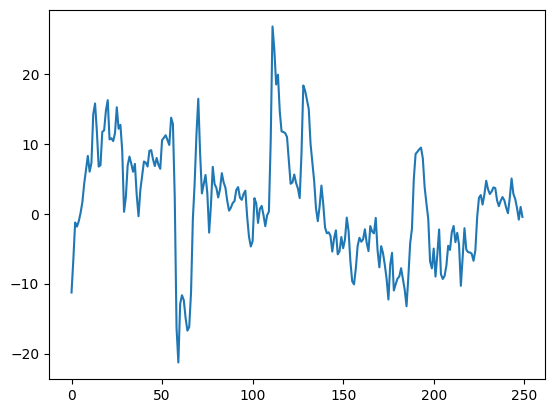

In [128]:
plt.plot(np_A_ready[0][100:350])

In [129]:
def arange_signals_dict(np_ready):
  signals_dict = dict()
  for i in range(NUMBER_OF_CHANNELS):
    key = 'Electrode ' + str(i)
    signals_dict[key] = np_ready[i]

  if EXTRACT_FREQUENCIES:
    for key in list(signals_dict.keys()):
      val = signals_dict.pop(key)
      for frequency_name, frequency_array in extract_frequency_powers(val).items():
        new_key = key + ' - ' + frequency_name
        signals_dict[new_key] = frequency_array

  return signals_dict

In [130]:
A_signals_dict = arange_signals_dict(np_A_ready)
B_signals_dict = arange_signals_dict(np_B_ready)

In [131]:
import pprint
pprint.pprint(A_signals_dict)

{'Electrode 0 - alpha': array([459.39576208, 513.98301103, 563.54692873, ..., 356.29452847,
       550.87882469, 745.6176383 ]),
 'Electrode 0 - beta': array([1337.33830839, 1114.73455913,  788.22090999, ..., 4320.94297731,
       5102.09713874, 8219.36372115]),
 'Electrode 0 - delta': array([1583.94718781, 1618.08069857, 1650.7007278 , ..., 1064.52466916,
       1031.08090913,  998.93833753]),
 'Electrode 0 - gamma': array([ 4228.04917141,  1697.01786218,   265.69457571, ...,
        3881.46889506,  3151.27367678, 13886.27490584]),
 'Electrode 0 - theta': array([ 872.06937192,  941.15121737, 1006.24205393, ...,   76.00853313,
        134.65044624,  203.22977741]),
 'Electrode 1 - alpha': array([2027.84807412, 2091.08214592, 2072.64310101, ..., 1122.33090991,
       1558.60543031, 2000.95431611]),
 'Electrode 1 - beta': array([ 8509.74350874,  9645.09854096,  9046.90256225, ...,
        4503.19020866, 10964.53595146, 18949.89080294]),
 'Electrode 1 - delta': array([4656.71364814, 4749.

In [132]:
print([len(v) for v in A_signals_dict.values()])
print([len(v) for v in B_signals_dict.values()])

[30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000]
[30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000]


### Testing The Algorithm

In [133]:
# Testing the coupling algorithm in a made up case with the same signal, delayed and with added noise.

In [134]:
import numpy as np
import statsmodels.api as sm


def show_arrays(arr_1, arr_2, until):
  plt.figure().set_figwidth(15)
  plt.plot(arr_1[:until], alpha=0.7)
  plt.plot(arr_2[:until], alpha=0.7)
  plt.show


def create_fake_lag(original_array, lag):
  return (original_array[:-lag], original_array[lag:])


def add_noise_with_stds(input_array, num_stds):
    std_original = np.std(input_array)
    noise = np.random.normal(0, std_original * num_stds, input_array.shape)
    noisy_array = input_array + noise
    return noisy_array


def test_coupling(arr_1, arr_2):
  eeg_signal1 = arr_1
  eeg_signal2 = arr_2
  eeg_data = np.column_stack((eeg_signal1, eeg_signal2))

  if FIND_BEST_LAG:
    max_lag_order = aic_best_lag * SAMPLE_RATE  # Limit max lag order
  else:
    max_lag_order = LAG_ORDER * SAMPLE_RATE  # Limit max lag order

  model = sm.tsa.VAR(eeg_data)
  results = model.fit(max_lag_order)
  return results


def test_coupling_with_noise(original, noise_std, fake_lag):
  original, lagged = create_fake_lag(original, fake_lag)
  minus_lagged = -lagged
  noisy_minus_lagged = add_noise_with_stds(minus_lagged, noise_std)

  print("Original Array STD:", original.std())
  print("Noisy Array STD:", noisy_minus_lagged.std())
  # show_arrays(original, noisy_minus_lagged, 500)

  results = test_coupling(original, noisy_minus_lagged)
  return results

#### Signal Transformations

In [135]:
if COUPLING_TESTS:
  a1, a2 = create_fake_lag(np_A_ready[0], 50)
  show_arrays(a1, a2, 1000)
  print(f'FPE of VAR model: {test_coupling(a1, a2).fpe}')

In [136]:
if COUPLING_TESTS:
  orig = np_A_ready[0][:5000]
  minus = -1.5 * orig
  show_arrays(orig, minus, 250)
  print(f'FPE of VAR model: {test_coupling(orig, minus).fpe}')

In [137]:
if COUPLING_TESTS:
  orig = np_A_ready[0][:5000]
  noisy = add_noise_with_stds(orig, 0.05)
  show_arrays(orig, noisy, 250)
  print(f'FPE of VAR model: {test_coupling(orig, noisy).fpe}')

In [138]:
if COUPLING_TESTS:
  orig = np_A_ready[0][:5000]
  noisy = add_noise_with_stds(orig, 0.03)
  results = test_coupling(orig, noisy)

  residuals = results.resid
  rmse = np.sqrt(np.mean(residuals ** 2, axis=1))

  until = 500

  plt.figure().set_figwidth(30)
  plt.plot(orig[:1000], alpha=0.7, label='A')
  plt.plot(noisy[:1000], alpha=0.7, label='B')
  plt.plot(rmse[:1000], alpha=0.7, label='fpe')
  plt.legend()
  plt.show

In [139]:
if COUPLING_TESTS:
  original = np_A_ready[0][:5000]
  original, lagged = create_fake_lag(original, 50)
  minus_lagged = -1.5 * lagged
  noisy_minus_lagged = add_noise_with_stds(minus_lagged, 0.05)

  show_arrays(orig, noisy_minus_lagged, 250)
  print(f'FPE of VAR model: {test_coupling(original, noisy_minus_lagged).fpe}')

In [140]:
if COUPLING_TESTS:
  original = np_A_ready[0][:5000]
  original, lagged = create_fake_lag(original, 125)
  minus_lagged = -1.5 * lagged
  noisy_minus_lagged = add_noise_with_stds(minus_lagged, 0.05)

  results = test_coupling(original, minus_lagged)

  residuals = results.resid
  rmse = np.sqrt(np.mean(residuals ** 2, axis=1))

  until = 500

  plt.figure().set_figwidth(30)
  plt.plot(original[:5000], alpha=0.7, label='A')
  plt.plot(minus_lagged[:5000], alpha=0.7, label='B')
  plt.plot(rmse[:5000], alpha=0.7, label='fpe')
  plt.legend()
  plt.show

#### Test Transformations

In [141]:
if COUPLING_TESTS:
  results = test_coupling_with_noise(np_A_ready[0][:5000], noise_std=0.2, fake_lag=150)
  print(f'Coupling result FPE: {results.fpe}')
  print(f'Coupling result pvalues: {results.pvalues_dt}')
  print(f'Coupling result tvalues: {results.tvalues_dt}')

In [142]:
def plot_coupling_fpe_over_noise_std(original_array, noises_list, fake_lag):
  fpes = np.zeros(len(noises_list))

  for i,noise in enumerate(noises_list):
    print(i)
    fpes[i] = test_coupling_with_noise(original_array, noise_std=noise, fake_lag=fake_lag).fpe

  plt.plot(noises_list, fpes)

  plt.title("FPE as a function of Added Noise")
  plt.xlabel("Noise in the Second Array in STD")
  plt.ylabel("FPE of the VAR Model")

  plt.show()

In [143]:
# Create the array with values increasing in a logarithmic scale
if COUPLING_TESTS:
  log_range_array = np.logspace(np.log10(0.1), np.log10(0.00001), 50)
  plot_coupling_fpe_over_noise_std(np_A_ready[0][:5000], log_range_array, 150)

In [144]:
if COUPLING_TESTS:
  original_array = np_A_ready[0][:5000]
  lags = np.arange(1, 500, 20)
  noise = 0

  fpes = np.zeros(len(lags))

  for i,lag in enumerate(lags):
    print(i)
    fpes[i] = test_coupling_with_noise(original_array, noise_std=noise, fake_lag=lag).fpe

  plt.plot(lags, fpes)

In [145]:
# So we can 'identify' coupling of only the LAG_ORDER
# In this case we introduced fake lag - and so we have a practical identifiable lag of LAG_ORDER - fake_lag => 250!!!

In [146]:
if COUPLING_TESTS:
  a1 = np_A_ready[0][:]
  a2 = np_B_ready[0][:]

  results = test_coupling(a1, a2)

In [147]:
if COUPLING_TESTS:
  print(results.fpe)

#### Random Arrays

In [148]:
if COUPLING_TESTS:
  std_original = 12
  length = 50000

  noise1 = np.random.normal(0, std_original, length)
  noise2 = np.random.normal(0, std_original, length)

  print(noise1.shape)
  print(test_coupling(noise1, noise2).fpe)

In [149]:
# The amount of noise does affect FPE while the length of the signals does not.

In [150]:
# The FPE of a trial is similar to the FPE of 2 random signals with noise std of 10-15.

#### Over Time

In [151]:
if COUPLING_TESTS:
  residuals = results.resid

  # Calculate the Root Mean Squared Error (RMSE) over time
  rmse = np.sqrt(np.mean(residuals ** 2, axis=1))

In [152]:
if COUPLING_TESTS:
  arr_1 = np_A_ready[0]
  arr_2 = np_B_ready[0]

  results = test_coupling(arr_1, arr_2)

  residuals = results.resid
  rmse = np.sqrt(np.mean(residuals ** 2, axis=1))

  until = 500

  plt.figure().set_figwidth(30)
  plt.plot(arr_1[:until], alpha=0.7, label='A')
  plt.plot(arr_2[:until], alpha=0.7, label='B')
  plt.plot(rmse[:until], alpha=0.7, label='rmse')
  plt.legend()
  plt.show

In [153]:
if COUPLING_TESTS:
  show_arrays(rmse, np_A_ready[0], 400)

### Coupling

#### Vector Auto Regression

In [154]:
# Search for Best Lag #
import numpy as np
import statsmodels.api as sm
from numpy.linalg import LinAlgError

if FIND_BEST_LAG:
  # Assuming you have two numpy arrays: eeg_signal1 and eeg_signal2
  eeg_signal1 = np_A_ready[0]
  eeg_signal2 = np_B_ready[0]

  # Stack the two signals vertically to create the multivariate time series data
  eeg_data = np.column_stack((eeg_signal1, eeg_signal2))

  # Find the Best Lag Order
  aic_best_lag, aic_best_result = -1, -1
  bic_best_lag, bic_best_result = -1, -1
  hqic_best_lag, hqic_best_result = -1, -1

  # Try different lag orders and compute evaluation criteria
  max_lag_order = MAXIMUM_LAG_FOR_SEARCH * SAMPLE_RATE  # Limit max lag order

  for lag_order in range(0, max_lag_order + 1, 50):
      print(lag_order)
      try:
          model = sm.tsa.VAR(eeg_data)
          results = model.fit(maxlags=lag_order)
          print(results.k_ar)

          aic = results.aic
          if aic < aic_best_result or aic_best_result == -1:
            aic_best_lag, aic_best_result = lag_order, aic

      except LinAlgError:
          print(f"Error occurred at lag order {lag_order}: The matrix is not positive definite.")

  print("Best Lag Order:")
  print(f"AIC: {aic_best_lag}")

In [155]:
def calculate_coupling(subject_A_data, subject_B_data):
  # Stack the two signals vertically to create the multivariate time series data
  data_for_coupling = np.vstack((subject_A_data, subject_B_data))
  data_for_coupling = np.transpose(data_for_coupling)
  print(data_for_coupling.shape)

  # Try different lag orders and compute evaluation criteria
  if FIND_BEST_LAG:
    max_lag_order = aic_best_lag * SAMPLE_RATE  # Limit max lag order
  else:
    max_lag_order = LAG_ORDER * SAMPLE_RATE  # Limit max lag order

  model = sm.tsa.VAR(data_for_coupling)
  result = model.fit(max_lag_order)
  return result

In [156]:
def coupling_one_versus_one(A_dict, B_dict):
  results_dict = dict()

  for sig_name, sig_val in A_dict.items():
    results_dict[sig_name] = calculate_coupling(sig_val, B_dict[sig_name])

  return results_dict


def coupling_one_versus_all(A_dict, B_dict):
  A_signals_stack = np.vstack(list(A_signals_dict.values()))
  B_signals_stack = np.vstack(list(B_signals_dict.values()))

  results_dict = dict()

  # Subject A
  for sig_name, sig_val in A_dict.items():
    new_sig_val = reset_dimensions(sig_val)
    result_key = 'Subject A - ' + sig_name
    results_dict[result_key] = calculate_coupling(new_sig_val, B_signals_stack)

  # Subject B
  for sig_name, sig_val in B_dict.items():
    new_sig_val = reset_dimensions(sig_val)
    result_key = 'Subject B - ' + sig_name
    results_dict[result_key] = calculate_coupling(new_sig_val, A_signals_stack)

  return results_dict


def coupling_all_versus_all(A_dict, B_dict):
  A_signals_stack = np.vstack(list(A_signals_dict.values()))
  B_signals_stack = np.vstack(list(B_signals_dict.values()))
  return {'all vs all FPE': calculate_coupling(A_signals_stack, B_signals_stack)}

In [157]:
if COUPLING_TYPE == 1: # One versus one
  results = coupling_one_versus_one(A_signals_dict, B_signals_dict)

elif COUPLING_TYPE == 2: # One versus all
  results = coupling_one_versus_all(A_signals_dict, B_signals_dict)

elif COUPLING_TYPE == 3: # All versus all
  results = coupling_all_versus_all(A_signals_dict, B_signals_dict)

(30000, 2)
(30000, 2)
(30000, 2)
(30000, 2)
(30000, 2)
(30000, 2)
(30000, 2)
(30000, 2)
(30000, 2)
(30000, 2)


### Misc

In [158]:
import numpy as np

def cross_correlation(eeg_signal_1, eeg_signal_2):
    # Assuming eeg_signal_1 and eeg_signal_2 are numpy arrays of EEG data

    # Normalize the signals to zero mean and unit variance
    eeg_signal_1 = (eeg_signal_1 - np.mean(eeg_signal_1)) / np.std(eeg_signal_1)
    eeg_signal_2 = (eeg_signal_2 - np.mean(eeg_signal_2)) / np.std(eeg_signal_2)

    # Compute cross-correlation using numpy.correlate or np.corrcoef
    cross_corr = np.correlate(eeg_signal_1, eeg_signal_2, mode='full')

    return cross_corr


import scipy.signal

def coherence(eeg_signal_1, eeg_signal_2, fs=250):
    # Assuming eeg_signal_1 and eeg_signal_2 are numpy arrays of EEG data
    # fs is the sampling frequency of the EEG data

    # Compute the Welch power spectral density (PSD) estimates
    f, Pxx_signal_1 = scipy.signal.welch(eeg_signal_1, fs=fs)
    _, Pxx_signal_2 = scipy.signal.welch(eeg_signal_2, fs=fs)

    # Compute the cross-power spectral density (CSD) estimate
    _, Cxy = scipy.signal.csd(eeg_signal_1, eeg_signal_2, fs=fs)

    # Compute coherence
    coherence = np.abs(Cxy) / np.sqrt(Pxx_signal_1 * Pxx_signal_2)

    return f, coherence


import scipy.stats

def mutual_information(eeg_signal_1, eeg_signal_2, bins=10):
    # Assuming eeg_signal_1 and eeg_signal_2 are numpy arrays of EEG data
    # bins is the number of bins for the histogram estimation

    # Compute histograms for the signals
    hist_1, _ = np.histogram(eeg_signal_1, bins=bins, density=True)
    hist_2, _ = np.histogram(eeg_signal_2, bins=bins, density=True)

    # Joint histogram
    hist_2d, _, _ = np.histogram2d(eeg_signal_1, eeg_signal_2, bins=bins, density=True)

    # Compute mutual information
    mi = scipy.stats.entropy(hist_2d.ravel(), np.outer(hist_1, hist_2).ravel())

    return mi

In [159]:
# 1. Granger Causality using VAR
def granger_causality():
    return results.test_causality(1, 0).pvalue  # Test if channel 1 Granger-causes channel 2

# 2. Temporal Dynamics using VAR
def temporal_dynamics():
    coefficients_channel_1, coefficients_channel_2 = results.coefs[:, :, 0], results.coefs[:, :, 1]
    return coefficients_channel_1, coefficients_channel_2

# 3. Connectivity Patterns using VAR
def connectivity_patterns():
    return results.coefs

### Results

In [160]:
def get_fpe_per_signal(results_dict):
  dict_fpe = dict()
  for sig_name, result in results_dict.items():
    dict_fpe[sig_name] = result.fpe
  return dict_fpe

def get_avg_fpe(results_dict):
  return np.mean(list(get_fpe_per_signal(results_dict).values()))

def get_min_fpe(results_dict):
  fpe_dict = get_fpe_per_signal(results_dict)
  sig_names = list(results_dict.keys())
  sig_names.sort(key = lambda x: fpe_dict[x])
  lowest = sig_names[0]

  return {lowest, fpe_dict[lowest]}

In [161]:
dict_fpe = get_fpe_per_signal(results)

In [162]:
import pprint

pprint.pprint(dict_fpe)

{'Electrode 0 - alpha': 0.00014956964300524684,
 'Electrode 0 - beta': 7.432779241843093e+16,
 'Electrode 0 - delta': 7.124562852370191e-13,
 'Electrode 0 - gamma': 1.52483493030786e+22,
 'Electrode 0 - theta': 2.9959698783585006e-08,
 'Electrode 1 - alpha': 0.0002541791115680806,
 'Electrode 1 - beta': 1.7233035958723018e+17,
 'Electrode 1 - delta': 1.373301392173251e-12,
 'Electrode 1 - gamma': 3.511354445022013e+22,
 'Electrode 1 - theta': 5.110601217093168e-08}


In [163]:
print(get_avg_fpe(results))

5.036214041145074e+21


In [164]:
print(get_min_fpe(results))

{'Electrode 0 - delta', 7.124562852370191e-13}


In [165]:
print(results['Electrode 1 - beta'].summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 04, Sep, 2023
Time:                     07:21:41
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    39.9116
Nobs:                     29800.0    HQIC:                   39.7599
Log likelihood:          -675121.    FPE:                1.72330e+17
AIC:                      39.6882    Det(Omega_mle):     1.67784e+17
--------------------------------------------------------------------
Results for equation y1
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const        1029.495532      1282.600558            0.803           0.422
L1.y1           4.698311         0.005829          805.990           0.000
L1.y2           0.051657         0.653294            0.079           0.937
L2.y1       